# SEResNeXt50

implemented by Tensorflow

SE Net 再原本的網路上添加 SE 模組

![](https://i.imgur.com/Mzhp8Bu.png)

## Load data

In [1]:
SEED = 2021
import os
os.environ['PYTHONHASHSEED'] = str(SEED)

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import random
import numpy

random.seed(SEED)
numpy.random.seed(SEED)
tf.random.set_seed(SEED)

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


170508288/170498071 [==============================] - 4s 0us/step


In [2]:
print(tf.test.gpu_device_name())
tf.config.list_physical_devices('GPU')


/device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preveiw photos

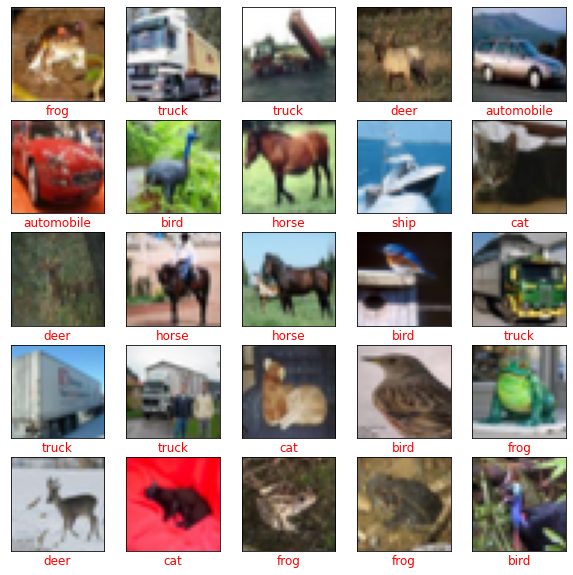

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]], color='red', fontsize='large')
plt.show()


## Build Model

本次主要在 SE block 的部分著墨，不詳加描術 ResNeXt 的部分

In [4]:
# reference https://github.com/titu1994/keras-squeeze-excite-network

def squeeze_excite_block(input, ratio=16):
    filters = input.shape[-1]

    se = input
    se = layers.GlobalAveragePooling2D()(se)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Activation('relu')(se)
    se = layers.Dense(filters, kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Activation('sigmoid')(se)
    
    return tf.multiply(input, se)


In [5]:
# 不考慮 channel_last 不然程式碼太長我懶得看

class GroupConv2D(layers.Conv2D):
    def __init__(self, filters,
            kernel_size,
            strides=(1, 1),
            padding='valid',
            data_format='channels_last',
            dilation_rate=(1, 1),
            num_group=1,
            activation=None,
            use_bias=True,
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros',
            kernel_regularizer=None,
            bias_regularizer=None,
            activity_regularizer=None,
            kernel_constraint=None,
            bias_constraint=None,
            **kwargs):
        super(GroupConv2D, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            dilation_rate=dilation_rate,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.num_group = num_group
        if self.filters % self.num_group != 0:
            raise ValueError('filters must divided by num_group with no remainders!')
        self.input_spec = layers.InputSpec(ndim=4)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        ## NOTICE: dim 要使用整數 原文章僅用 /
        kernel_shape = self.kernel_size + (input_dim//self.num_group, self.filters)

        ## NOTICE: self.add_weight() 原文章可能因參數順序有寫錯因此有修改
        self.kernel = self.add_weight(name='kernel', shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(name='bias', shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = layers.InputSpec(ndim=self.rank + 2)
        self.built = True
        self.channel_num = input_dim


    def call(self, inputs):
        filter_in_group = int(self.filters // self.num_group)
        
        outputs_list = []
        input_in_group = int(self.channel_num // self.num_group)

        for i in range(self.num_group):
            outputs = K.conv2d(
                inputs[:, :, :, i*input_in_group:(i+1)*input_in_group],
                self.kernel[:, :, :, i*filter_in_group:(i+1)*filter_in_group],
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

            if self.use_bias:
                outputs = K.bias_add(
                    outputs,
                    self.bias[i*filter_in_group:(i+1)*filter_in_group],
                    data_format=self.data_format)
            outputs_list.append(outputs)

        outputs = tf.concat(outputs_list, axis=-1)
        return outputs

    def get_config(self):
        config = super(layers.Conv2D, self).get_config()
        config.pop('rank')
        config['num_group'] = self.num_group
        return config


![](https://i.imgur.com/1e5Upbt.png)

In [6]:
def resNeXtUnit(name, filterList, input):
    x = layers.Conv2D(filterList[0], 1, use_bias=False, name=name+'_conv1')(input)
    x = layers.BatchNormalization(name=name+'_bn1')(x)
    x = layers.Activation('relu', name=name+'_relu1')(x)
    
    x = layers.ZeroPadding2D(padding = (1, 1))(x)
    x = GroupConv2D(filterList[1], kernel_size=(3,3), use_bias=False, num_group=32, name=name+'_conv2')(x)
    x = layers.BatchNormalization(name=name+'_bn2')(x)
    x = layers.Activation('relu', name=name+'_relu2')(x)
    
    x = layers.Conv2D(filterList[2], (1, 1), use_bias=False, name=name+'_conv3')(x)
    x = layers.BatchNormalization(name=name+'_bn3')(x)
    return x

![](https://i.imgur.com/oU305Wc.png)

In [7]:
def stage(id, units, filterList, input):
    for i in range(1, units+1):
        name = 'stage_%d_unit_%d_' % (id, i)
        x1 = input
        x1 = resNeXtUnit(name=name, filterList=filterList, input=x1)
        if i == 1:
            x2 = layers.Conv2D(filterList[2], 1, use_bias=False, name=name+'sc')(input)
            x2 = layers.BatchNormalization()(x2)
        else:
            x2 = input

        # Add SE Block here
        x2 = squeeze_excite_block(x2)

        input = tf.add(x1, x2)
        input = layers.Activation('relu', name=name+"relu")(input)
    return input


In [8]:
def ResNeXt50(input_shape, outputs=10):
    input = layers.Input(shape=input_shape)
    x = layers.BatchNormalization()(input)
    x = layers.ZeroPadding2D((3, 3))(x)
    x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D((1,1))(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)

    x = stage(id=1, units=3, filterList=[128, 128, 256], input=x)
    x = stage(id=2, units=4, filterList=[128, 128, 256], input=x)
    x = stage(id=3, units=6, filterList=[128, 128, 256], input=x)
    x = stage(id=4, units=3, filterList=[128, 128, 256], input=x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(outputs)(x) 
    # 不做 activation 因為 loss 是用 SparseCategoricalCrossentropy(from_logits=True)
    
    return models.Model(input, x)

## Training

In [9]:
# The image size in CIFAR10 is 32*32 RGB
m = ResNeXt50((32,32,3), 10)
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
______________________________________________________________________________________________

In [11]:
m.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])
history = m.fit(train_images, train_labels, batch_size=100, epochs=50,
        validation_data=(test_images, test_labels))

Epoch 1/50
500/500 [==============================] - 138s 225ms/step - loss: 1.0657 - accuracy: 0.6211 - val_loss: 1.1588 - val_accuracy: 0.6091
Epoch 2/50
500/500 [==============================] - 107s 215ms/step - loss: 0.8888 - accuracy: 0.6894 - val_loss: 1.0067 - val_accuracy: 0.6651
Epoch 3/50
500/500 [==============================] - 107s 215ms/step - loss: 0.7670 - accuracy: 0.7337 - val_loss: 1.0016 - val_accuracy: 0.6780
Epoch 4/50
500/500 [==============================] - 107s 215ms/step - loss: 0.6743 - accuracy: 0.7649 - val_loss: 0.9859 - val_accuracy: 0.6778
Epoch 5/50
500/500 [==============================] - 107s 215ms/step - loss: 0.6012 - accuracy: 0.7917 - val_loss: 0.7948 - val_accuracy: 0.7318
Epoch 6/50
500/500 [==============================] - 107s 214ms/step - loss: 0.5332 - accuracy: 0.8150 - val_loss: 0.8021 - val_accuracy: 0.7416
Epoch 7/50
500/500 [==============================] - 107s 213ms/step - loss: 0.4824 - accuracy: 0.8343 - val_loss: 0.7784 -

## Evaluate the model

313/313 - 18s - loss: 1.1340 - accuracy: 0.7898


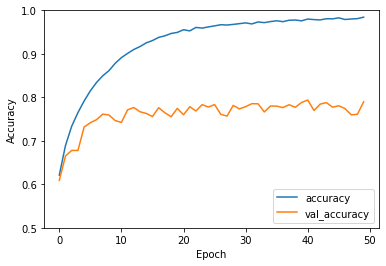

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = m.evaluate(test_images,  test_labels, verbose=2)